In [1]:
import sys
sys.path.insert(0, '..')
#for local import of parent dict

import scanpy as sc
import pandas as pd
import numpy as np
import pathlib
import scipy
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from ggml.plot import plot_heatmap, hier_clustering, plot_emb, plot_ellipses
from ggml.generator import get_pointcloud
from tqdm import tqdm

import ot

3.684928337231172e-15


/home/kuehn/anaconda3/envs/ggml_umap_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_threads = 20

norm=1 #"fro" 

iter = 30
t = 3
neighbor_t = [t] #,5,7
rank_k = [5] #,10,25,50,100,200] 

alphas = [0.1,1,10,100,1000] #,10,50,100]
lambdas = [0.1,1,10,100,1000] 

In [3]:
#move into package TODO

def get_cells_by_patients(adata_path,patient_col="donor_id",label_col="reported_diseases",subsample_patient_ratio=0.5,n_feats=None,max_cells = None,filter_genes=False,**kwargs):
    global adata
    adata = sc.read_h5ad(adata_path+".h5ad")  #adata_path+".h5ad")
    print(adata)

    string_class_labels = np.unique(adata.obs[label_col])

    if filter_genes:
        #detect low variable genes
        gene_var = np.var(adata.X.toarray(),axis=0)
        #filter
        thresh = np.mean(gene_var) #TODO make this not hardcoded and arbitrary
        adata = adata[:,gene_var >thresh]
        #adata.write(adata_path+"_filtered.h5ad")

    distributions = []
    distributions_class = []
    patient_labels = []
    disease_labels = []
    celltype_node_label = []

    if n_feats is not None:
        global pca
        pca = PCA(n_components=n_feats, svd_solver='auto')
        pca.fit(adata.X)
    unique_patients = np.unique(adata.obs[patient_col])
    unique_patients_subsampled = np.random.choice(unique_patients, size = int(len(unique_patients)*subsample_patient_ratio),replace=False)


    for patient in unique_patients_subsampled:
        
        
        patient_adata = adata[adata.obs[patient_col] == patient]

        disease_label = np.unique(patient_adata.obs[label_col].to_numpy())
        string_class_label = disease_label[0]
        
        if len(disease_label) > 1:
            print("Warning, sample_ids refer to cells with multiple disease labels (likely caused by referencing by patients and having multiple samples from different zones)")

        '''
        unique,pos = np.unique(patient_adata.obs[label_col].to_numpy(),return_inverse=True) #Finds all unique elements and their positions
        counts = np.bincount(pos)                     #Count the number of each unique element
        maxpos = counts.argmax()                      #Finds the positions of the maximum count
        string_class_label = unique[maxpos] #we take the label that occurs most often for this patient
        patient_adata = adata[adata.obs[label_col] == string_class_label ] # and only keep those (this is only relevant for myocardial infarction)
        '''

        if max_cells is not None and patient_adata.n_obs > max_cells:
            sc.pp.subsample(patient_adata,n_obs = max_cells) 

        #p_arr = np.asarray(patient_adata.X.toarray(),dtype="f") #TODO directly sparse scipy matrix to numpy matrix?

        #if n_feats == 50:
        #    p_arr = np.asarray(patient_adata.obsm["X_pca"],dtype="f")
        #else:
        p_arr = np.asarray(patient_adata.X.toarray(),dtype="f") #TODO directly sparse scipy matrix to numpy matrix?
        if n_feats is not None:
            p_arr = pca.transform(p_arr)

        distributions.append(p_arr)
        
        disease_labels.append(string_class_label)
        #distributions_class.append(np.where(string_class_labels==string_class_label)[0][0])
        patient_labels.append(list(patient_adata.obs[patient_col]))
        celltype_node_label.append(list(patient_adata.obs['cell_type'])) #cell_Type
            
        #Cell level
    points = np.concatenate(distributions) #np.reshape(np.asarray(dists),(-1,2))
    point_labels = sum([[l] * len(D) for l,D in zip(disease_labels,distributions)],[]) #flattens list of lists

    #return distributions, distributions_class, patient_labels, disease_labels, celltype_node_label
    return distributions, disease_labels, points, point_labels, celltype_node_label, np.concatenate(patient_labels)

    distributions, distributions_class, patient_labels, disease_labels, 

#distributions, distributions_labels, patient_labels = get_cells_by_patients(dataset_folder+dataset_name,patient_col="donor_id",label_col=label_col)
#print(distributions_labels)

def compute_OT(distributions,labels,precomputed_distances=None,ground_metric = None,w = None,legend=None,numThreads=n_threads):
    D = np.zeros((len(distributions),len(distributions)))
    for i,distribution_i in enumerate(distributions):
        for j,distribution_j in enumerate(distributions):
            if i < j:
                if precomputed_distances is not None:
                    start_i = int(np.sum([len(dist) for dist in distributions[:i]]))
                    start_j = int(np.sum([len(dist) for dist in distributions[:j]]))
                    if precomputed_distances.ndim == 1:
                        precomputed_distances = scipy.spatial.distance.squareform(precomputed_distances)
                    M = precomputed_distances[start_i:start_i+len(distribution_i),start_j:start_j+len(distribution_j)]
                elif w is not None:
                    M = pairwise_mahalanobis_distance_npy(distribution_i,distribution_j,w)

                D[i,j] = ot.emd2([],[],M,numThreads=numThreads)
                #TODO handle non mahalanobis distances
            else:
                D[i,j]=D[j,i]
    
    hardcoded_symbols = None #[i % 4 for i in range(len(distributions))]
    plot_emb(D,method='umap',colors=labels,symbols=hardcoded_symbols,legend=legend,title="UMAP",verbose=True,annotation=None,s=200)
    plot_emb(D,method='diffusion',colors=labels,symbols=hardcoded_symbols,legend=legend,title="DiffMap",verbose=True,annotation=None,s=200)

    hier_clustering(D,labels, ax=None,dist_name="W_θ")
    return D

from sklearn.metrics.pairwise import pairwise_distances

def pairwise_mahalanobis_distance_npy(X_i,X_j=None,w=None,numThreads=n_threads):
    # W has shape dim x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 
    if X_j is None:
        if w is None or isinstance(w,str):
            return pairwise_distances(X_i,metric=w,n_jobs=numThreads) #cdist .. ,X_j)
        else:
            if w.ndim == 2 and w.shape[0]==w.shape[1]:
                return pairwise_distances(X_i,metric="mahalanobis",n_jobs=numThreads,VI =w)    
            else:
                X_j = X_i
    #Transform poins of X_i,X_j according to W
    #refactor pls
    if w is None or isinstance(w,str):
        return pairwise_distances(X_i,X_j,metric=w,n_jobs=numThreads) #cdist .. ,X_j)
    #elif w.ndim == 2 and w.shape[0]==w.shape[1] and len(w)>1000:
    #mahalanobis matrix is to large to compute distances, use cholesky factorization instead M=wT w
            

            #return pairwise_distances(X_i,metric="mahalanobis",n_jobs=numThreads,VI =w)
            #     
    #return scipy.spatial.distance.squareform(scipy.spatial.distance.cdist(X_i,X_j,metric=w))

    #Assume w is cov matrix of mahalanobis distance
    elif w.ndim == 1:
        #assume cov=0, scale dims by diagonal
        w = np.diag(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)

        #proj_X_i = X_i * w[None,:]
        #proj_X_j = X_j * w[None,:]
    else: 
        w = np.transpose(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)
    
    #print("projected shape")
    #print(proj_X_i.shape)
    return np.linalg.norm(proj_X_i[:,np.newaxis,:]  -  proj_X_j[np.newaxis,:,:],axis=-1)  


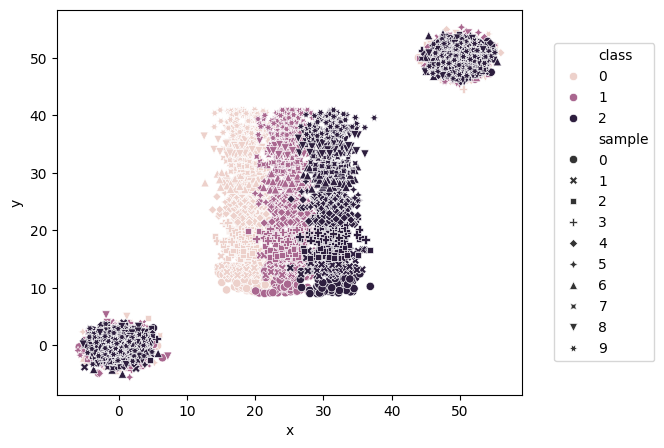

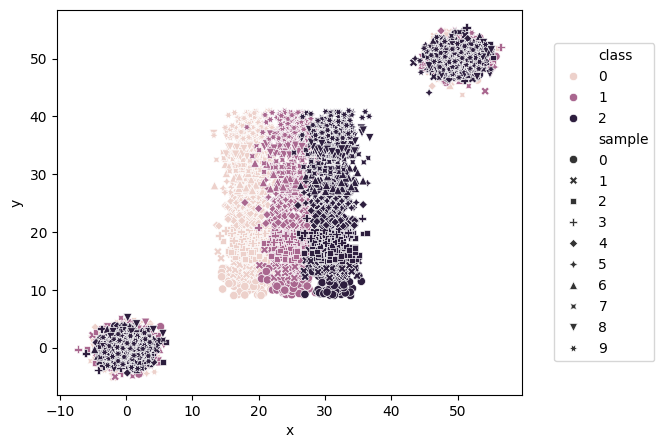

In [4]:
#Synth Data

n = 100
means = [5,10,15]
offsets = np.arange(0,30,3)+1.5

shared_means_x = [0, 40]
shared_means_y = [0, 50] 


use_synth = True
if use_synth:   
    datasets = {
        #"synth_2D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1000,noise_dims=1),
        #"synth_100D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=99)
        "synth_200D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=199)
    }

    train_datasets = {
        #"synth_2D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1000,noise_dims=1),
        #"synth_100D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=99)
        "synth_200D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=199)
    }
else:
    datasets = {}
    train_datasets = {}

In [5]:


load_scRNA = False
if load_scRNA:#
    #Load scRNA datasets
    dataset_folder = "/home/kuehn/ot_metric_learning/damin-ggml/data/datasets/"
    dataset_loading = {
        #"breastcancer":{"path":"b8b5be07-061b-4390-af0a-f9ced877a068","label_col":"reported_diseases","patient_col":"donor_id"},
        #"kidney":{"path":"1c360b0b-eb2f-45a3-aba9-056026b39fa5","label_col":"disease","patient_col":"donor_id"},
        "myocard_infarct":{"path":"c1f6034b-7973-45e1-85e7-16933d0550bc","label_col":"patient_group","patient_col":"sample"}, #major_labls
    }




    
    pca_c = None #50
    max_cells = 500 #None # 
    subsample_patient_ratio = 1.0

    for dataset_name,loading_info in dataset_loading.items():
        #Test
        data_dict = {}
        data_dict["distributions"],data_dict["distributions_labels"],data_dict["points"], data_dict["point_labels"], data_dict["distribution_modes"], data_dict["patient"] = get_cells_by_patients(dataset_folder+loading_info["path"],loading_info["patient_col"],loading_info["label_col"],subsample_patient_ratio=subsample_patient_ratio,n_feats=pca_c,max_cells = max_cells,filter_genes=True)
        datasets[dataset_name] = data_dict

        #Train
        data_dict2 = {}
        data_dict2["distributions"],data_dict2["distributions_labels"],data_dict2["points"], data_dict2["point_labels"], data_dict2["distribution_modes"], data_dict2["patient"] = get_cells_by_patients(dataset_folder+loading_info["path"],loading_info["patient_col"],loading_info["label_col"],subsample_patient_ratio=0.5,n_feats=pca_c,max_cells = max_cells,filter_genes=True)
        train_datasets[dataset_name] = data_dict2


In [6]:
metric_params = {}

In [7]:
from metric_learn import LMNN, LFDA, MLKR, NCA, ITML_Supervised
'''
metrics = {
    "GGML": None,
    "Euclidean": lambda _: "euclidean", # lambda dims:np.eye(dims),
    "Manhatten": lambda _ : "cityblock",
    #"Jaccard": lambda _ : "jaccard",
    "Cosine": lambda _ : "cosine",
    #"LMNN": lambda data:LMNN(n_neighbors=30,random_state=42,learn_rate=1e-6,max_iter=100).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    "LFDA": lambda data:LFDA(k=3).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    #"NCA" : lambda data: NCA(random_state=42).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    
    "ITML": lambda data: ITML_Supervised(random_state=42).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    
}
'''


metrics = {f"theta_{a}_{l}_{t}_5_iter{iter}_L{norm}": None for a in alphas for l in lambdas}

#Load params for learned metric
metric_params_path = "/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters"

#If pipeline should only be rerun for some datasets
selected_datasets = datasets #["breastcancer_full"] #


for d in tqdm(selected_datasets):
    print(d)
    if d not in metric_params:
        metric_params[d] = {}
    for m in tqdm(metrics):
        print(m)
        if m not in metric_params[d]:
            try:
                if callable(metrics[m]):
                    #print(datasets[d]["points"])
                    dims = datasets[d]["points"][0].shape[-1]
                    #print(dims)
                    metric_params[d][m]= metrics[m](train_datasets[d])
                else:
                    metric_params[d][m]=np.load(f"{metric_params_path}/{d}/GGML/{m}.npy") #hardcoded for hyperparameter tuning of synth 200D
            except Exception as e: 
                print(e)
                metric_params[d][m] = None


  0%|          | 0/1 [00:00<?, ?it/s]

synth_200D


100%|██████████| 1/1 [00:00<00:00, 17.07it/s]

theta_0.1_0.1_3_5_iter30_L1
theta_0.1_1_3_5_iter30_L1
theta_0.1_10_3_5_iter30_L1
theta_0.1_100_3_5_iter30_L1
theta_0.1_1000_3_5_iter30_L1
theta_1_0.1_3_5_iter30_L1
theta_1_1_3_5_iter30_L1
theta_1_10_3_5_iter30_L1
theta_1_100_3_5_iter30_L1
theta_1_1000_3_5_iter30_L1
theta_10_0.1_3_5_iter30_L1
theta_10_1_3_5_iter30_L1
theta_10_10_3_5_iter30_L1
theta_10_100_3_5_iter30_L1
theta_10_1000_3_5_iter30_L1
theta_100_0.1_3_5_iter30_L1
theta_100_1_3_5_iter30_L1
theta_100_10_3_5_iter30_L1
theta_100_100_3_5_iter30_L1
theta_100_1000_3_5_iter30_L1
theta_1000_0.1_3_5_iter30_L1
theta_1000_1_3_5_iter30_L1
theta_1000_10_3_5_iter30_L1
theta_1000_100_3_5_iter30_L1
theta_1000_1000_3_5_iter30_L1


In [8]:
from ggml.benchmark import pivoted_chol

rank = 5

#metric_params_copy= metric_params

#low rank cholesky approximation (pivoted)
for d in metric_params:
    for m in metric_params[d]:
        if isinstance(metric_params[d][m],np.ndarray):
            print(m)
            print(metric_params[d][m].shape)
            if len(metric_params[d][m])>100:
                get_diag = lambda: np.diagonal(metric_params[d][m]).copy()
                get_row = lambda i: metric_params[d][m][i,:]

                metric_params[d][m] = pivoted_chol(get_diag, get_row, rank, err_tol = 1e-6)
                print(metric_params[d][m].shape)

theta_0.1_0.1_3_5_iter30_L1
(5, 200)
theta_0.1_1_3_5_iter30_L1
(5, 200)
theta_0.1_10_3_5_iter30_L1
(5, 200)
theta_0.1_100_3_5_iter30_L1
(5, 200)
theta_0.1_1000_3_5_iter30_L1
(5, 200)
theta_1_0.1_3_5_iter30_L1
(5, 200)
theta_1_1_3_5_iter30_L1
(5, 200)
theta_1_10_3_5_iter30_L1
(5, 200)
theta_1_100_3_5_iter30_L1
(5, 200)
theta_1_1000_3_5_iter30_L1
(5, 200)
theta_10_0.1_3_5_iter30_L1
(5, 200)
theta_10_1_3_5_iter30_L1
(5, 200)
theta_10_10_3_5_iter30_L1
(5, 200)
theta_10_100_3_5_iter30_L1
(5, 200)
theta_10_1000_3_5_iter30_L1
(5, 200)
theta_100_0.1_3_5_iter30_L1
(5, 200)
theta_100_1_3_5_iter30_L1
(5, 200)
theta_100_10_3_5_iter30_L1
(5, 200)
theta_100_100_3_5_iter30_L1
(5, 200)
theta_100_1000_3_5_iter30_L1
(5, 200)
theta_1000_0.1_3_5_iter30_L1
(5, 200)
theta_1000_1_3_5_iter30_L1
(5, 200)
theta_1000_10_3_5_iter30_L1
(5, 200)
theta_1000_100_3_5_iter30_L1
(5, 200)
theta_1000_1000_3_5_iter30_L1
(5, 200)


In [9]:
#wrapper for precomputed distance matrix
#only execute once values are accessed
class Computed_Distances():
    def __init__(self, points, theta, n_threads=n_threads):
        self.n_treads = n_threads
        self.points = points
        self.theta = theta

        
        self.data = np.full((len(points),len(points)), np.nan)

        self.ndim = self.data.ndim
        self.sape = self.data.shape
        #self.shape =  ((len(points),len(points)))

    

    def __getitem__(self, slice_):
        #TODO check if some values are already computed and only compute new values

        if np.isnan(self.data[slice_]).any():
            ranges = [np.squeeze(np.arange(len(self.data))[slice_[i]]) for i in range(len(slice_))] #list(range(slice_[i].stop)[slice_[i]]) for i in range(len(slice_))]
            entry_nan_index = ([],[])
            for entry in ranges[0]:
                #print(self.data[entry,:].ndim)
                check = np.isnan(self.data[entry,:])
                if check.ndim == 2 and np.isnan(self.data[entry,:][:,slice_[1]]).any():
                    entry_nan_index[0].append(entry) 
                elif check.ndim == 1 and np.isnan(self.data[entry,:][slice_[1]]).any():
                    entry_nan_index[0].append(entry)   
            for entry in ranges[1]:
                if np.isnan(self.data[slice_[0],entry]).any():
                    entry_nan_index[1].append(entry)   
            #print("checked for nans")
            
            #check for elements with nan entries
            dist = pairwise_mahalanobis_distance_npy(self.points[entry_nan_index[0],:],self.points[entry_nan_index[1],:],w=self.theta, numThreads = n_threads)
            self.data[np.ix_(entry_nan_index[0],entry_nan_index[1])] = dist 
            #self.data[slice_[0],:][:,slice_[1]] =  pairwise_mahalanobis_distance_npy(self.points[slice_[0],:],self.points[slice_[1],:],w=self.theta, numThreads = n_threads) #self.data[slice_[0],:][:,slice_[1]] should be self.data[slice_]
            #print(self.data[np.ix_(entry_nan_index[0],entry_nan_index[1])]) #self.data[entry_nan_index[0],:][:,entry_nan_index[1]])
            #print(self.data[slice_[0],:][:,slice_[1]])

            computed_percentage = len(entry_nan_index[0])/len(ranges[0])*len(entry_nan_index[1])/len(ranges[1])
            #print(f"loaded {1-computed_percentage:,.2f} of {len(entry_nan_index[0])*len(entry_nan_index[0])} distances")
            return self.data[slice_]

        else:
            return self.data[slice_]

#Precompute ground distances with learned metrics ##actually we are just setting the wrapper instead
precomputed_ground_distances = {}
for d in metric_params:
    print(d)




    precomputed_ground_distances[d]={}
    for m in metric_params[d]:
        print(m)
        #print(datasets[d]["points"].shape)
        #print(metric_params[d][m].shape)
        #print(metric_params[d][m])
       
        if metric_params[d][m] is not None:
            if True:
               
                precomputed_ground_distances[d][m] = Computed_Distances(np.asarray(datasets[d]["points"],dtype='f'),theta=metric_params[d][m]) #pairwise_mahalanobis_distance_npy(np.asarray(datasets[d]["points"],dtype='f'),w=metric_params[d][m])
            #except Exception as e: 
            #    print(e)
            #    print("error")
            #    precomputed_ground_distances[d][m] = None
        else: 
            precomputed_ground_distances[d][m] = None


synth_200D
theta_0.1_0.1_3_5_iter30_L1
theta_0.1_1_3_5_iter30_L1
theta_0.1_10_3_5_iter30_L1
theta_0.1_100_3_5_iter30_L1
theta_0.1_1000_3_5_iter30_L1


theta_1_0.1_3_5_iter30_L1
theta_1_1_3_5_iter30_L1
theta_1_10_3_5_iter30_L1
theta_1_100_3_5_iter30_L1
theta_1_1000_3_5_iter30_L1
theta_10_0.1_3_5_iter30_L1
theta_10_1_3_5_iter30_L1
theta_10_10_3_5_iter30_L1
theta_10_100_3_5_iter30_L1
theta_10_1000_3_5_iter30_L1
theta_100_0.1_3_5_iter30_L1
theta_100_1_3_5_iter30_L1
theta_100_10_3_5_iter30_L1
theta_100_100_3_5_iter30_L1
theta_100_1000_3_5_iter30_L1
theta_1000_0.1_3_5_iter30_L1
theta_1000_1_3_5_iter30_L1
theta_1000_10_3_5_iter30_L1
theta_1000_100_3_5_iter30_L1
theta_1000_1000_3_5_iter30_L1


In [10]:
def datapoint_acc_over_splits(pred,true,index,length):
    prediction = np.zeros((length,2))
    for s_pred,s_true,s_index in zip(pred,true,index):
        prediction[s_index,0] += np.squeeze([s_pred == s_true]) # 1 #correct
        prediction[s_index,1] += np.squeeze([s_pred != s_true]) #+= 1 #false

    accuracy = prediction[:,0] / np.sum(prediction,axis=-1)
    return accuracy

In [11]:
import numpy.typing as npt
import warnings

#from pyvoi import VI #TODO

def VI(labels1: npt.NDArray[np.int32],labels2: npt.NDArray[np.int32],torch: bool=True,device: str="cpu",return_split_merge: bool=False):
    """
    Calculates the Variation of Information between two clusterings.

    Arguments:
    labels1: flat int32 array of labels for the first clustering
    labels2: flat int32 array of labels for the second clustering
    torch: whether to use torch, default:True
    device: device to use for torch, default:"cpu"
    return_split_merge: whether to return split and merge terms, default:False

    Returns:
    vi: variation of information
    vi_split: split term of variation of information
    vi_merge: merge term of variation of information
    splitters(optional): labels of labels2 which are split by labels1. splitters[i,0] is the contribution of the i-th splitter to the VI and splitters[i,1] is the corresponding label of the splitter
    mergers(optional): labels of labels1 which are merging labels from labels2. mergers[i,0] is the contribution of the i-th merger to the VI and mergers[i,1] is the corresponding label of the merger
    """
    if labels1.ndim > 1 or labels2.ndim > 1:
        warnings.warn(f"Inputs of shape {labels1.shape}, {labels2.shape} are not one-dimensional -- inputs will be flattened.")
        labels1 = labels1.flatten()
        labels2 = labels2.flatten()
        
    if torch:
        return VI_torch(labels1,labels2,device=device,return_split_merge=return_split_merge)
    else:
        return VI_np(labels1,labels2,return_split_merge=return_split_merge)
    
def VI_np(labels1,labels2,return_split_merge=False):
    assert len(labels2)==len(labels1)
    size=len(labels2)

    mutual_labels=(labels1.astype(np.uint64)<<32)+labels2.astype(np.uint64)

    sm_unique,sm_inverse,sm_counts=np.unique(labels2,return_inverse=True,return_counts=True)
    fm_unique,fm_inverse,fm_counts=np.unique(labels1,return_inverse=True,return_counts=True)
    _,mutual_inverse,mutual_counts=np.unique(mutual_labels,return_inverse=True,return_counts=True)

    terms_mutual = -np.log(mutual_counts/size)*mutual_counts/size
    terms_mutual_per_count=terms_mutual[mutual_inverse]/mutual_counts[mutual_inverse]
    terms_sm = -np.log(sm_counts/size)*sm_counts/size
    terms_fm = -np.log(fm_counts/size)*fm_counts/size
    if not return_split_merge:
        terms_mutual_sum=np.sum(terms_mutual_per_count)
        vi_split=terms_mutual_sum-terms_sm.sum()
        vi_merge=terms_mutual_sum-terms_fm.sum()
        vi=vi_split+vi_merge
        return vi,vi_split,vi_merge

    vi_split_each=np.zeros(len(sm_unique))
    np.add.at(vi_split_each,sm_inverse,terms_mutual_per_count)
    vi_split_each-=terms_sm
    vi_merge_each=np.zeros(len(fm_unique))
    np.add.at(vi_merge_each,fm_inverse,terms_mutual_per_count)
    vi_merge_each-=terms_fm

    vi_split=np.sum(vi_split_each)
    vi_merge=np.sum(vi_merge_each)
    vi=vi_split+vi_merge

    i_splitters=np.argsort(vi_split_each)[::-1]
    i_mergers=np.argsort(vi_merge_each)[::-1]

    vi_split_sorted=vi_split_each[i_splitters]
    vi_merge_sorted=vi_merge_each[i_mergers]

    splitters=np.stack([vi_split_sorted,sm_unique[i_splitters]],axis=1)
    mergers=np.stack([vi_merge_sorted,fm_unique[i_mergers]],axis=1)
    return vi,vi_split,vi_merge,splitters,mergers

In [12]:
from scipy.cluster.hierarchy import dendrogram
import sklearn
#import pyvoi
'''
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
data = "synth_2D"
metric = "GGML"
labels= np.asarray(datasets[data]["point_labels"])
distances = precomputed_ground_distances[data][metric]
l = 0

for t in np.arange(0.05,1,0.05):
#hier_clustering(distances[:,:],labels)
    print(t)
    pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(labels)) if l==1 else None,distance_threshold= None if l==1 else np.quantile(distances[:,:],t),metric='precomputed',linkage='average').fit_predict(distances[:,:])

    vi,_,_=VI(pred_cluster,labels,torch=False) #pyvoi.

    print(vi)

    mi_score = sklearn.metrics.mutual_info_score(labels,pred_cluster) #
    ari_score = sklearn.metrics.adjusted_rand_score(labels,pred_cluster) 
    
    #dist = np.copy(distances[:,:])
    #np.fill_diagonal(dist, 0)
    #sh_score = sklearn.metrics.silhouette_score(dist, labels, metric="precomputed")
    print(f"MI:{mi_score:.2f}  ARI:{ari_score:.2f}   VI:{vi:.2f}")
#pred_cluster = pred_cluster.fit(distances[:,:])
                            
#plot_dendrogram(pred_cluster, truncate_mode=None) #"level", p=3)

'''

'\ndef plot_dendrogram(model, **kwargs):\n    # Create linkage matrix and then plot the dendrogram\n\n    # create the counts of samples under each node\n    counts = np.zeros(model.children_.shape[0])\n    n_samples = len(model.labels_)\n    for i, merge in enumerate(model.children_):\n        current_count = 0\n        for child_idx in merge:\n            if child_idx < n_samples:\n                current_count += 1  # leaf node\n            else:\n                current_count += counts[child_idx - n_samples]\n        counts[i] = current_count\n\n    linkage_matrix = np.column_stack(\n        [model.children_, model.distances_, counts]\n    ).astype(float)\n\n    # Plot the corresponding dendrogram\n    dendrogram(linkage_matrix, **kwargs)\ndata = "synth_2D"\nmetric = "GGML"\nlabels= np.asarray(datasets[data]["point_labels"])\ndistances = precomputed_ground_distances[data][metric]\nl = 0\n\nfor t in np.arange(0.05,1,0.05):\n#hier_clustering(distances[:,:],labels)\n    print(t)\n    

In [13]:
patient_group_split = False # True
classify = True
cluster = False# True
results = {}
results_path = "/home/kuehn/ot_metric_learning/damin-ggml/data/results/clustering"

#TODO make this setable on a dataset level, and not global
true_modes_available = True

Data synth_200D Metric theta_0.1_0.1_3_5_iter30_L1
3000
computed


/home/kuehn/anaconda3/envs/ggml_umap_2/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


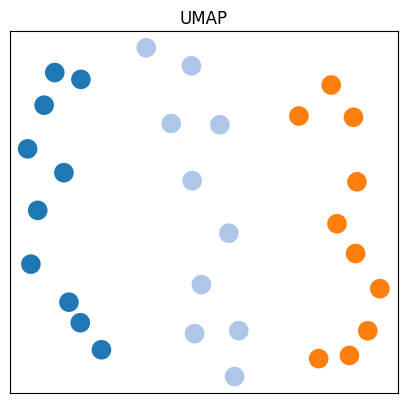

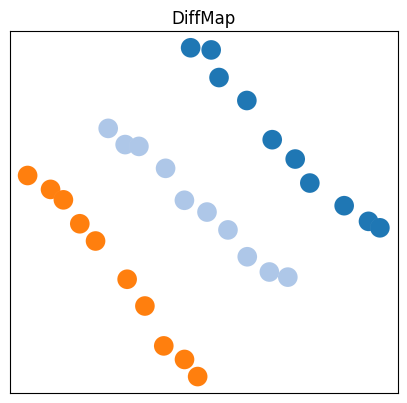

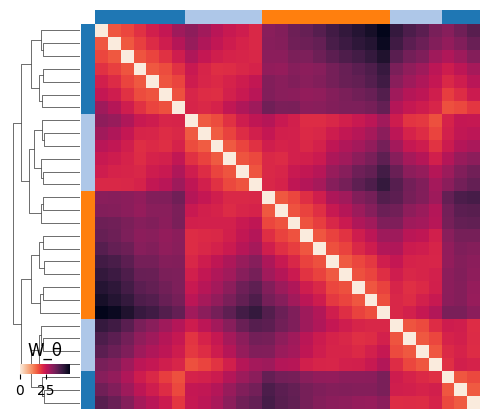

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

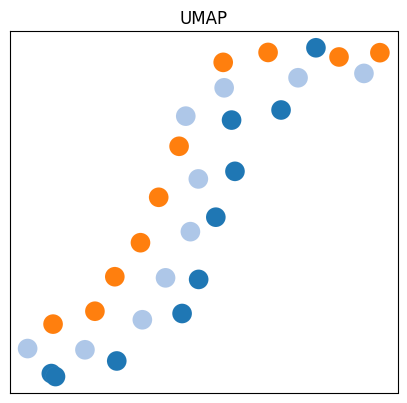

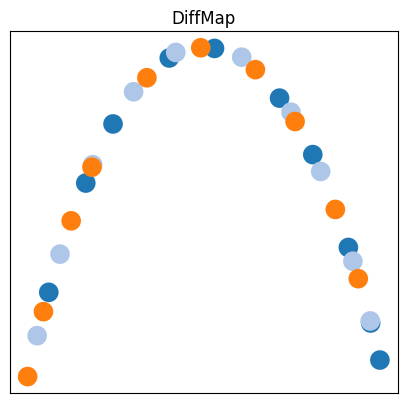

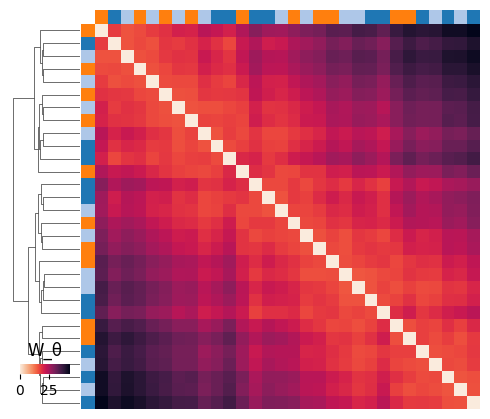

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

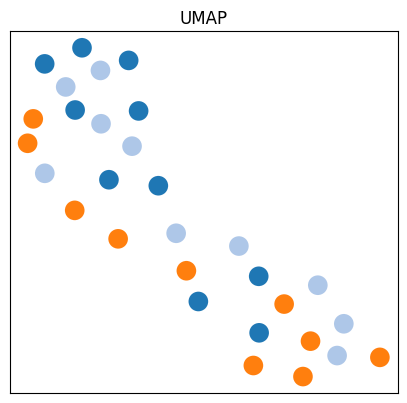

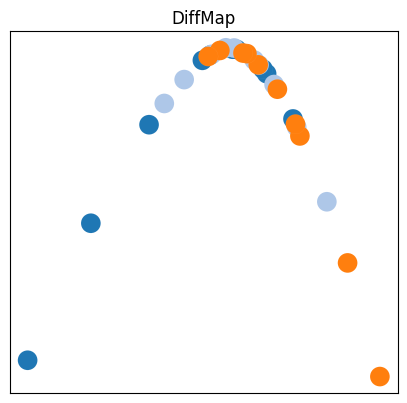

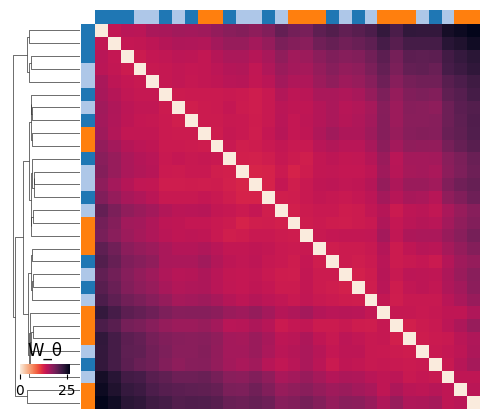

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

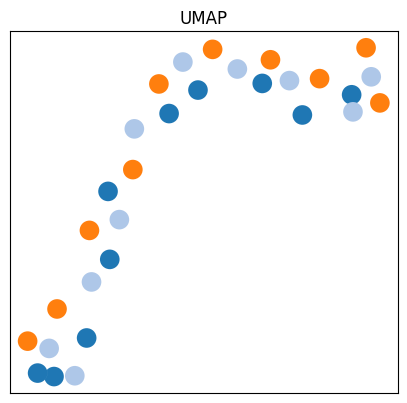

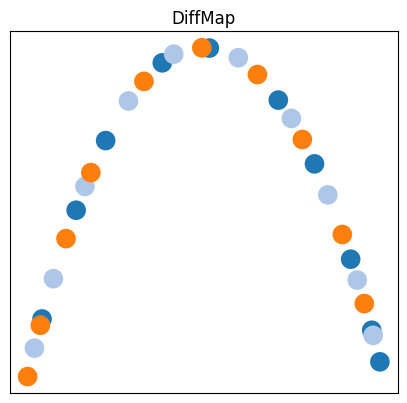

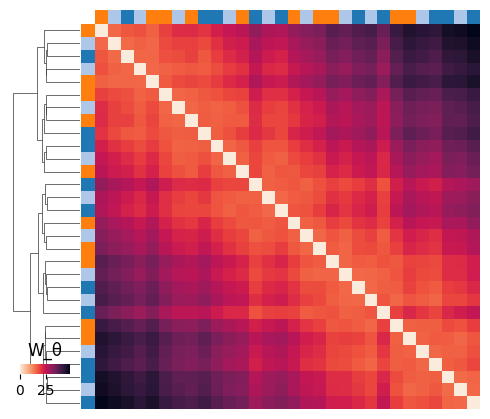

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

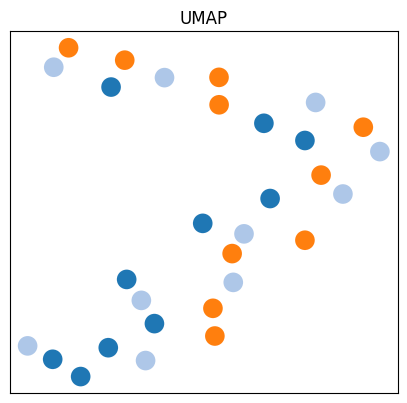

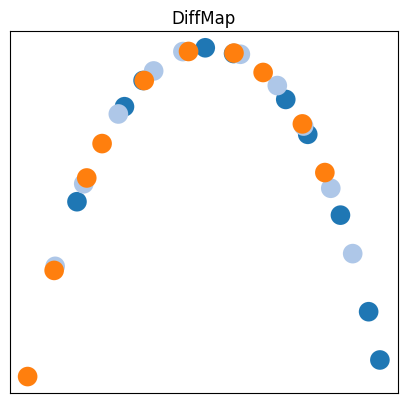

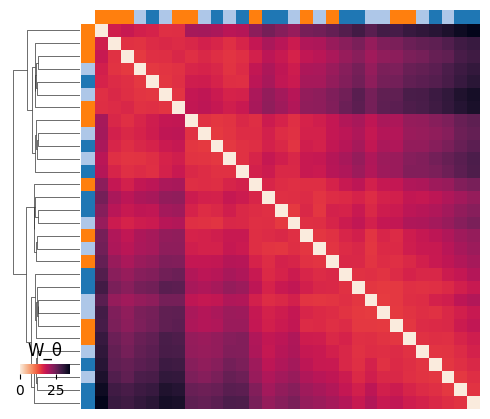

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

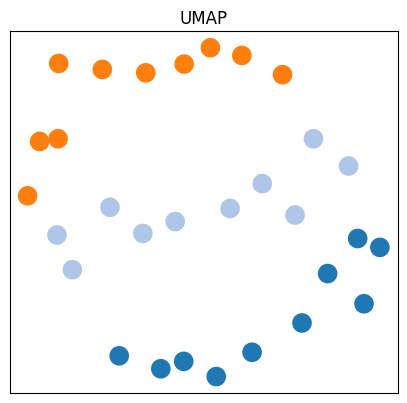

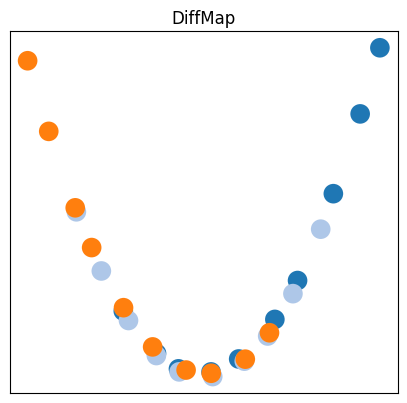

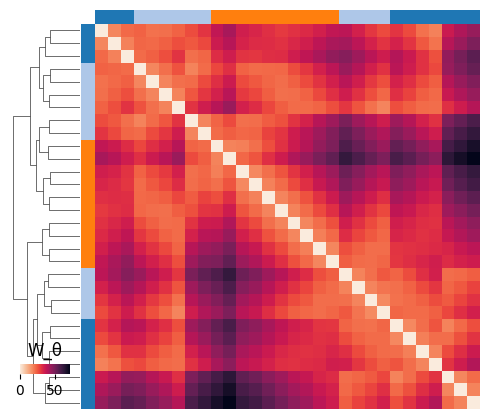

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

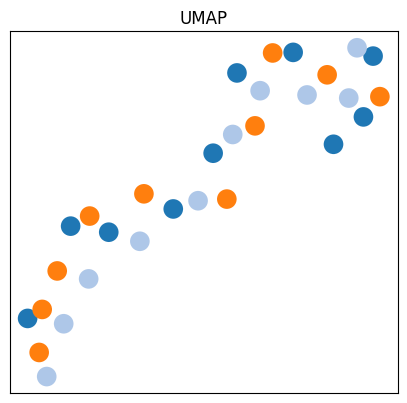

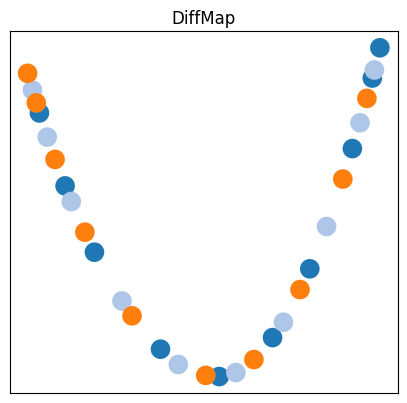

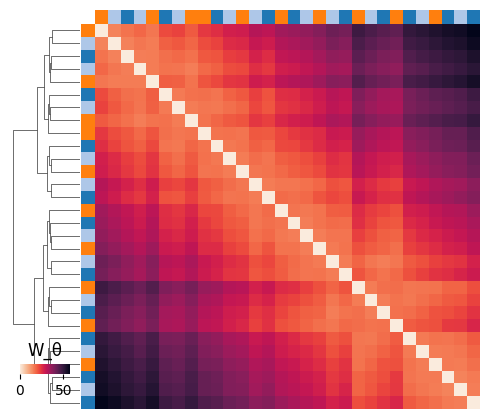

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

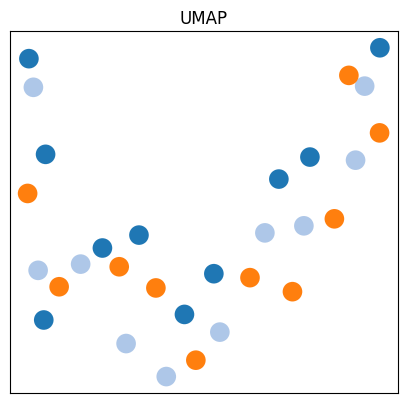

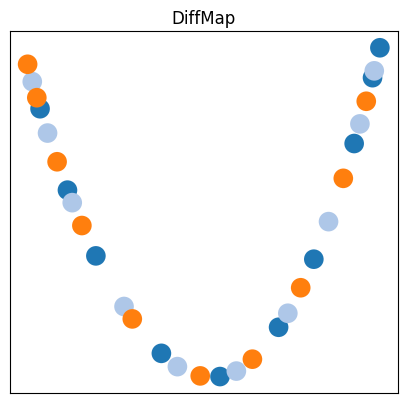

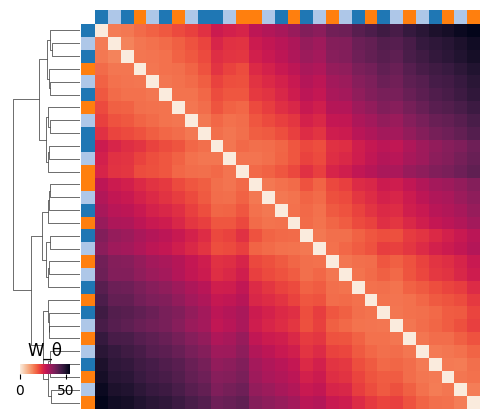

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

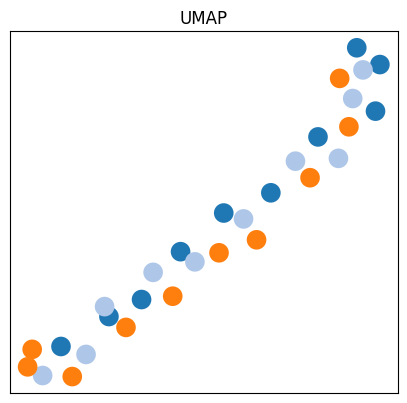

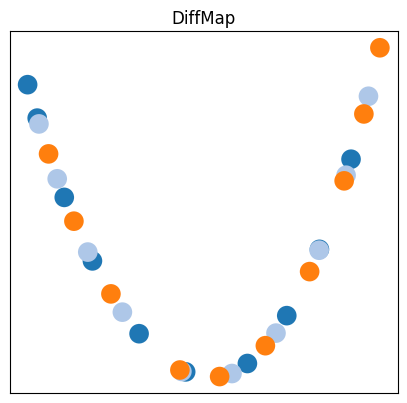

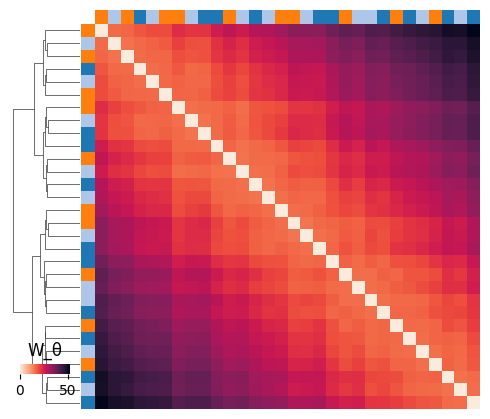

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

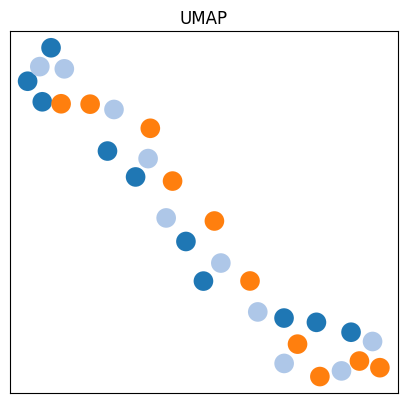

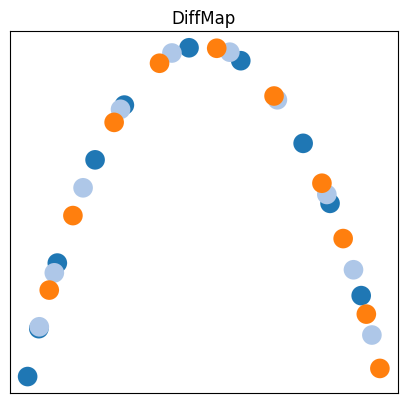

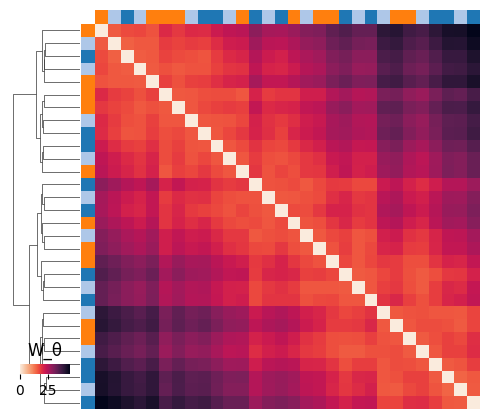

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

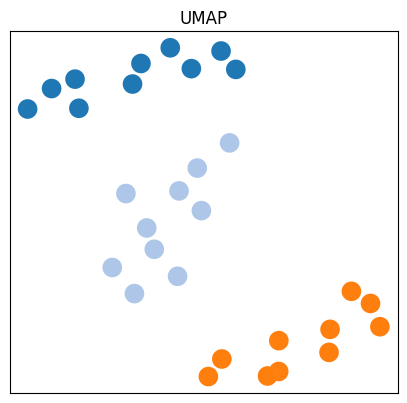

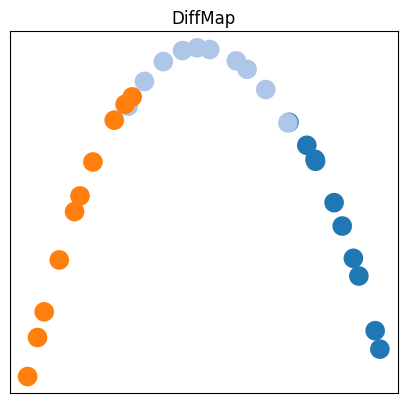

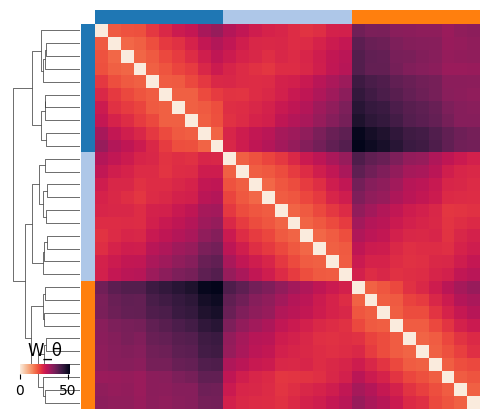

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

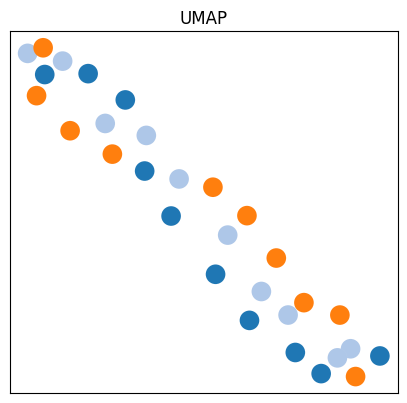

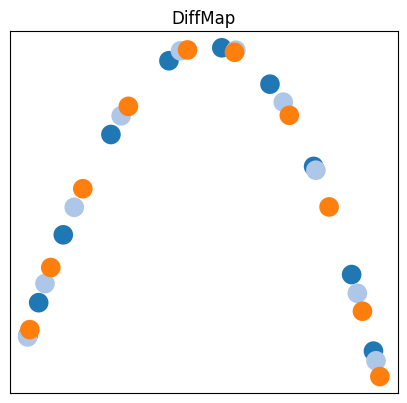

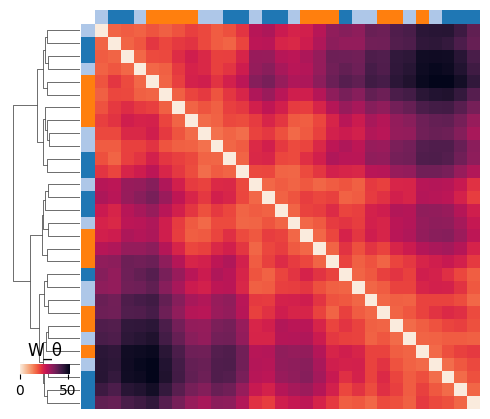

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

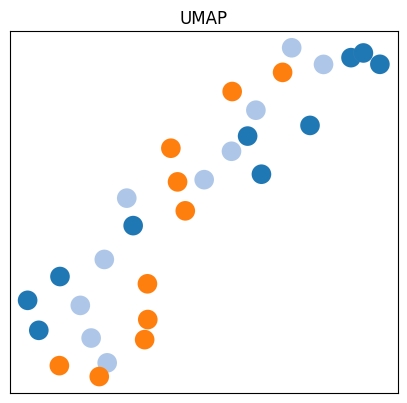

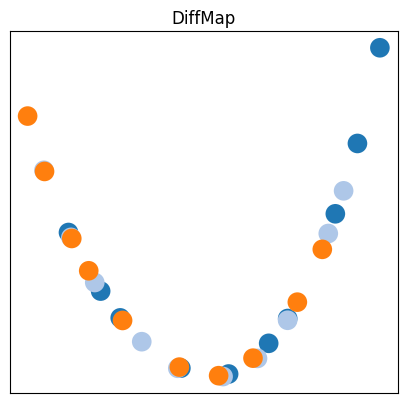

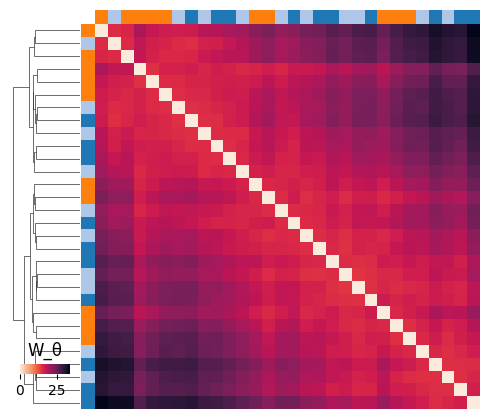

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

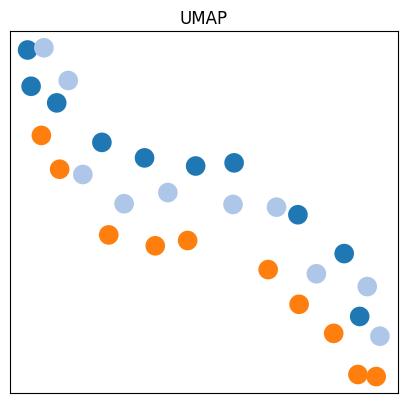

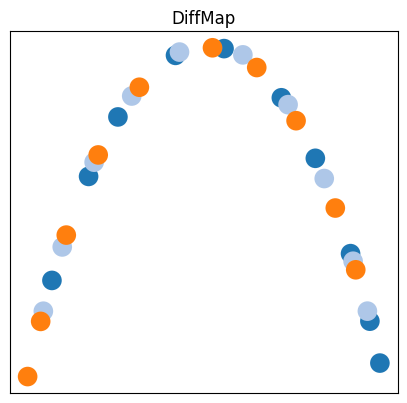

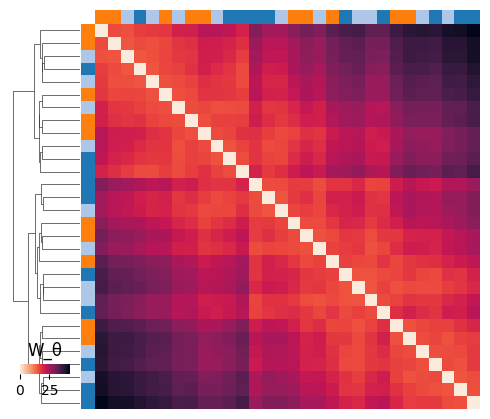

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

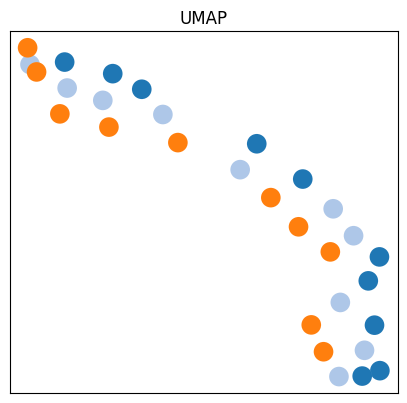

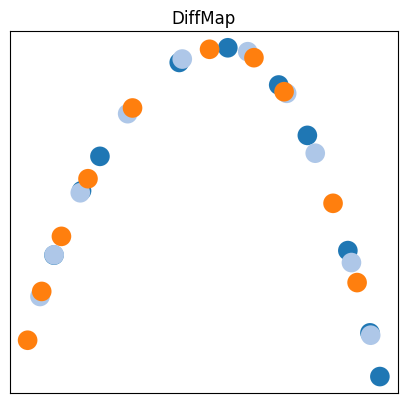

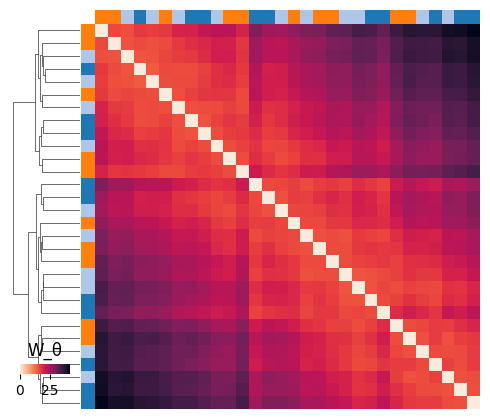

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

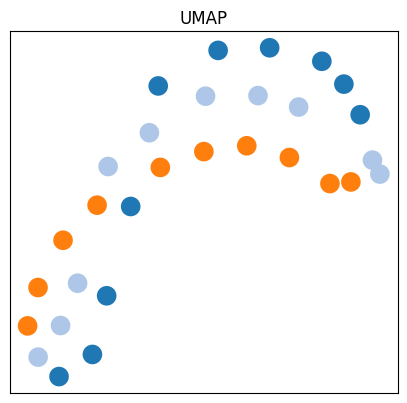

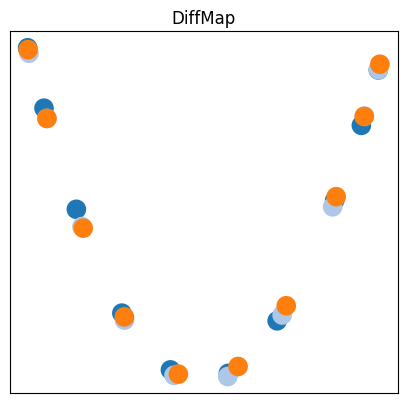

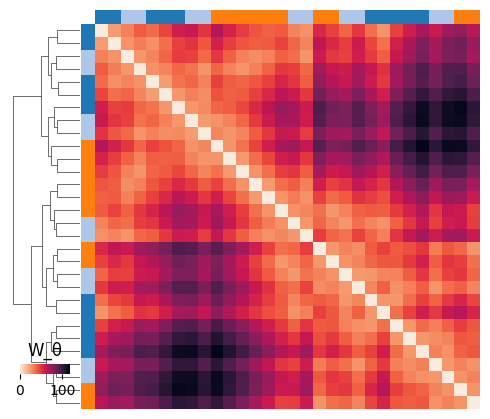

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

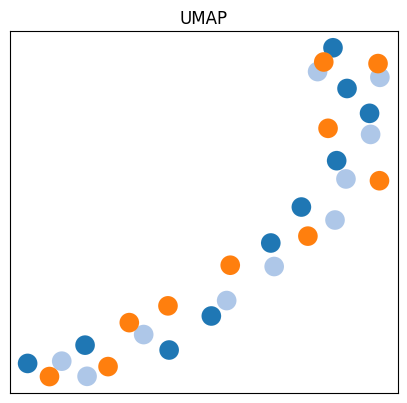

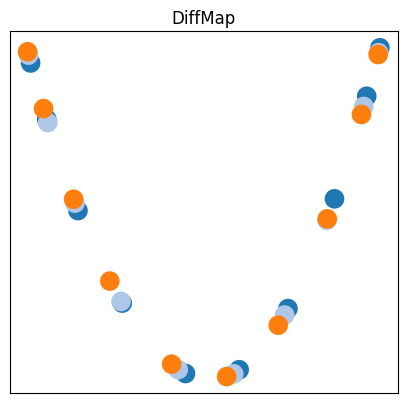

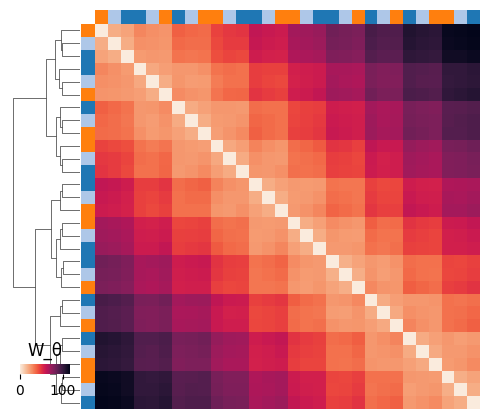

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

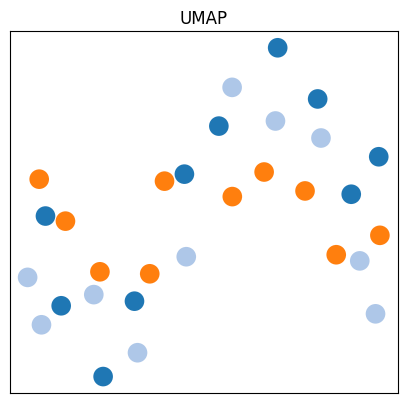

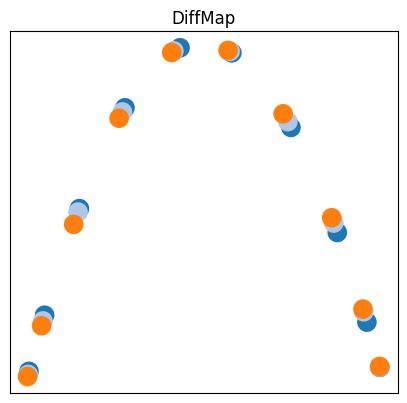

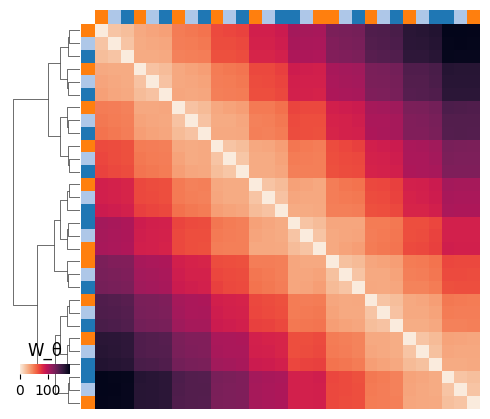

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

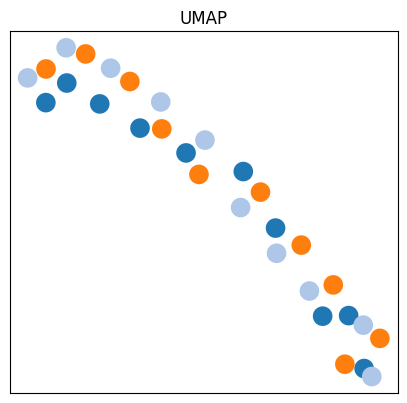

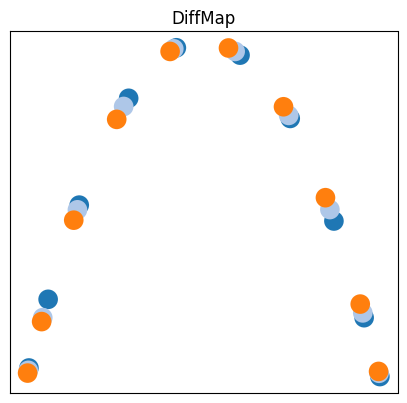

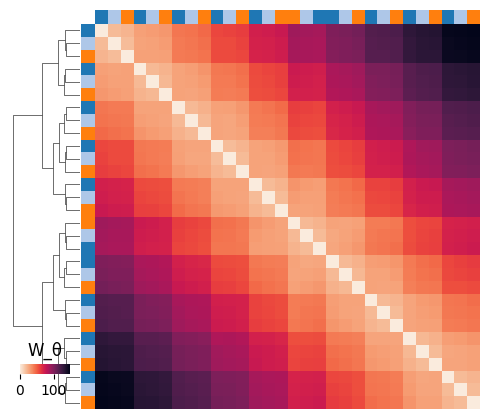

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

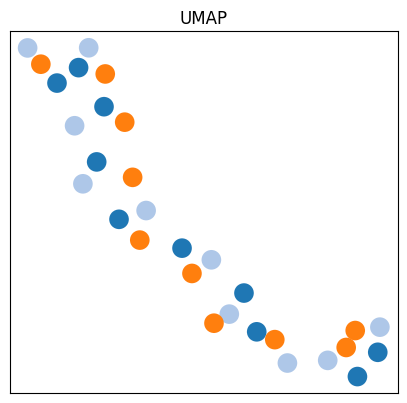

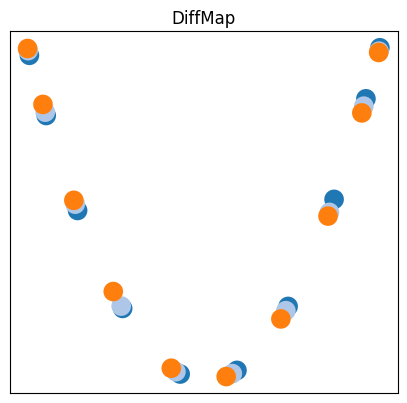

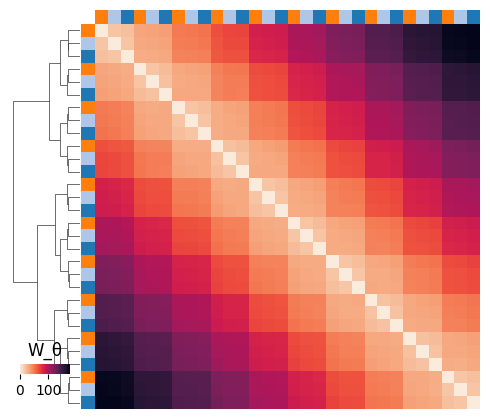

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

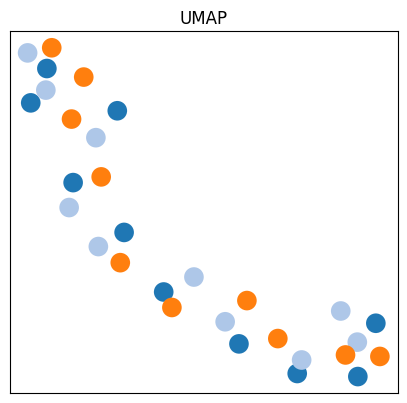

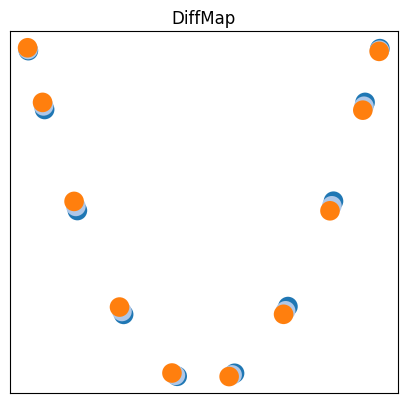

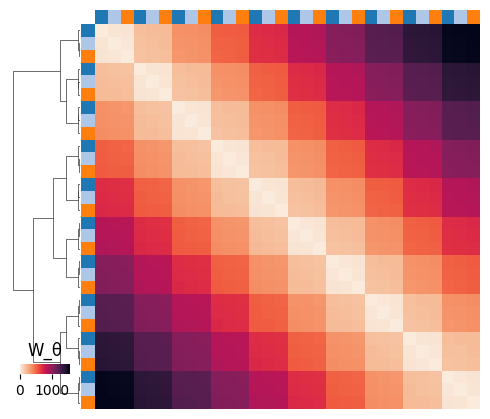

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

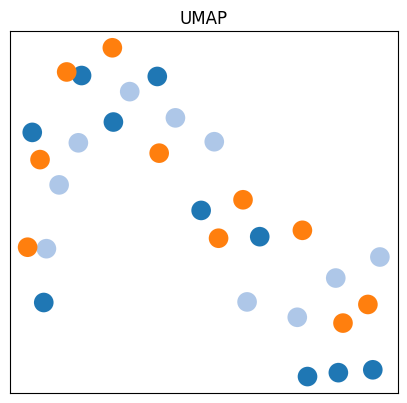

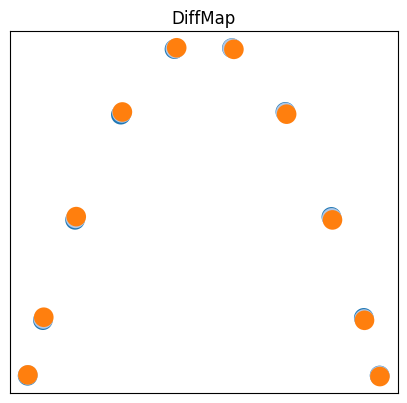

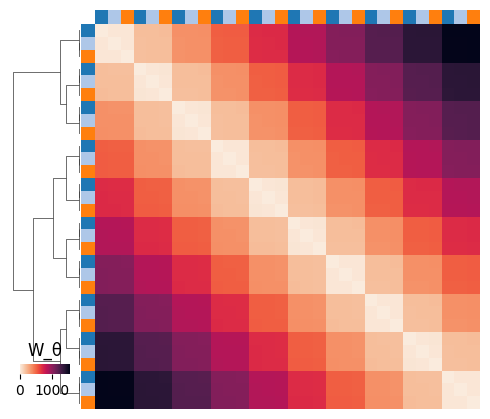

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

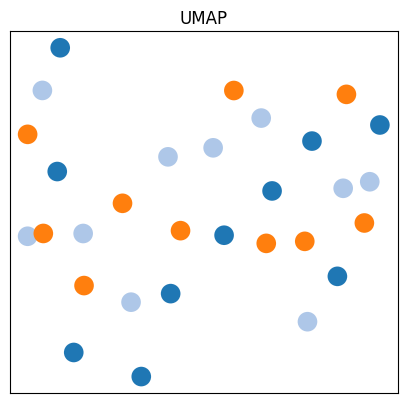

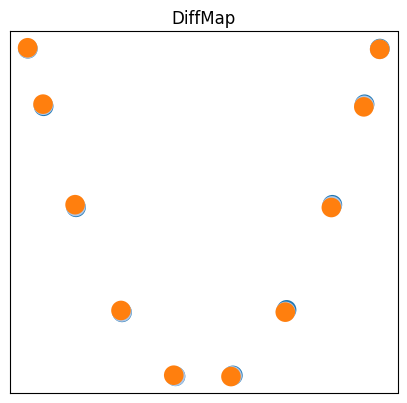

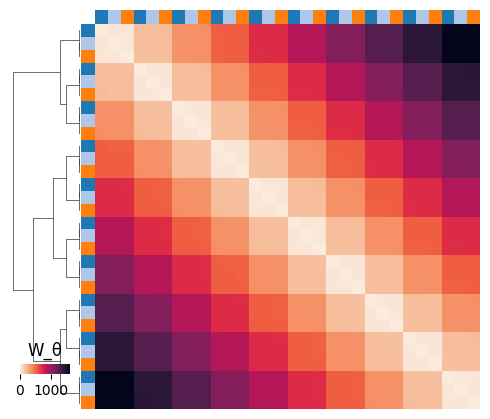

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

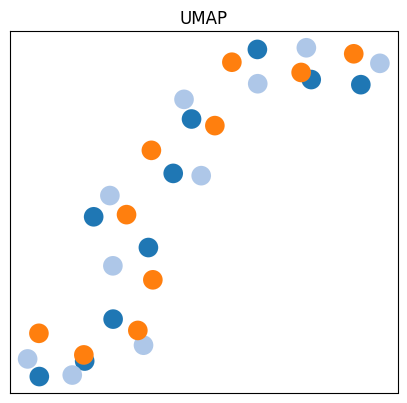

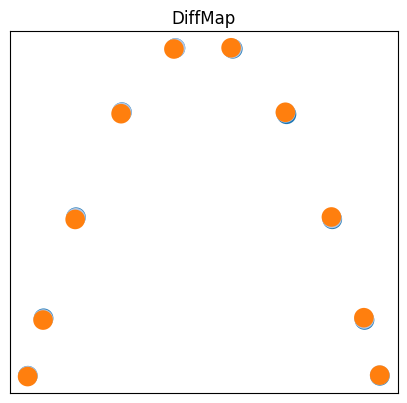

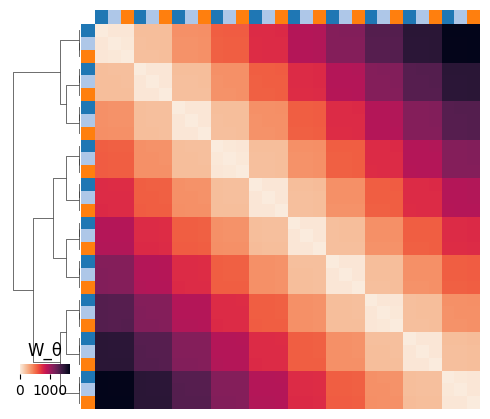

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

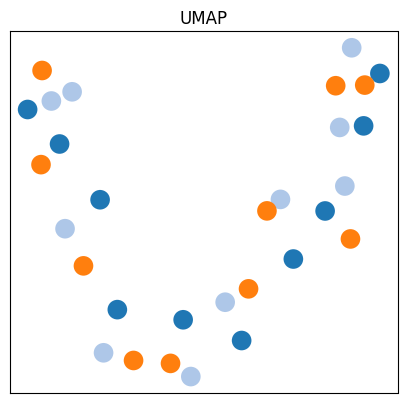

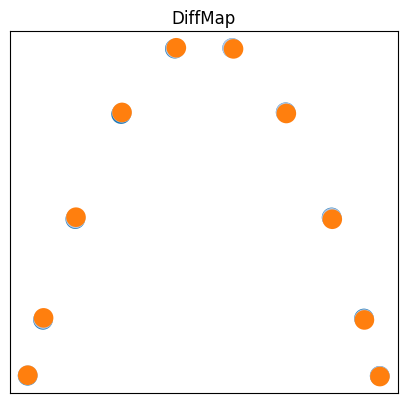

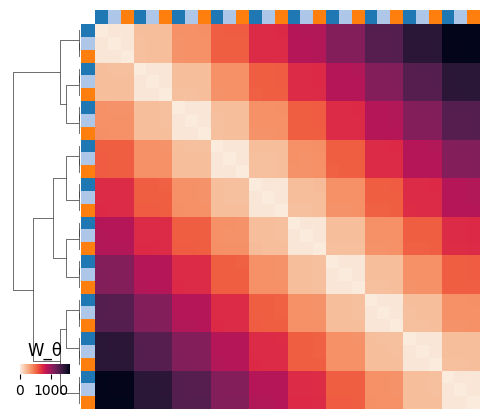

classification
(3000,)
(3000,)
[ 860 1001 2521 ... 2812  818 2972]
[2062  743 2927 1218 2350 1581 2205 1445 2420 2669  955 2717  534  925
 2393 2291 1199 1042 2286 2127  136 1291 2107 2561 2636  828 2193 2278
 1312 1975 2005 1554 2690  840 2294  669 1631 2112 1672  657 1330 1561
  764  747 1923 2211 2379  974 1483 2198 1961  584 1796 1642 2535 2579
 1580 1374  297 1394  284  843 2508 1934 2845 2232  347 2524  674  727
  393 1974 2151 1301  937  917  595 2848  446 2775 2538 1800 1549 2261
 2273  207 2937 2433 2391  800 2683 1186 2575 1896  490  290 2251  322
 2610 1785 1717 1147 1626  981 1355 2403  881 1241  787  189 2917  833
  281 2223  480 1953 1224 2831 1132 2486 1865  772 2614 1056   16  539
 1032 2123   67 2031 1898 2432  889 1535 2020 1389 2357  326 2477 1965
 2431  854 1831 2702 1422  504   59 2551  547 1837 1469 2414 2955 2586
  890 1266 2916 2189  649 2862  394  514 2784  866 2411  163  914  712
  111 1155 1428  469  449 1265  455  871  426 1286 2140  879  348 2555
   24  720

In [14]:
%load_ext autoreload
%autoreload 2

#Classification
import sklearn 
import scipy as sp
from ggml.benchmark import knn_from_dists, plot_table, plot_1split
import pickle

train_size=0.6
test_size =0.2
validation_size= 0.2

for d,data in enumerate(precomputed_ground_distances):
    results[data]={}

    for m, (metric_name, distances) in enumerate(precomputed_ground_distances[data].items()):
        print(f"Data {data} Metric {metric_name}")


        if distances is None:
            results[data][metric_name]=None    
        else:
            
            if True:
            #try:
                points = np.asarray(datasets[data]["points"])
                point_labels = np.asarray(datasets[data]["point_labels"])
                if true_modes_available:
                    points = points[np.asarray(datasets[data]["patient"])==1]
                    point_labels = point_labels[np.asarray(datasets[data]["patient"])==1]
                    print(len(point_labels))
                    #print(len(np.where(np.asarray(datasets[data]["patient"])==1)[0]))
                    mode_ind = np.ix_(np.where(np.asarray(datasets[data]["patient"])==1)[0],np.where(np.asarray(datasets[data]["patient"])==1)[0])

                    element_level = (distances[mode_ind], point_labels)
                    print("computed")
                    #print(distances[mode_ind].shape)
                else:
                    element_level = (distances, point_labels)
                distribution_level = (compute_OT(datasets[data]["distributions"],datasets[data]["distributions_labels"],precomputed_distances=distances,numThreads=n_threads),datasets[data]["distributions_labels"])
            #except Exception as e:
            #    print(e)
            #    results[data][metric_name]=None  

            results[data][metric_name]={"global":{},"ground":{}}
            for l, (distances,labels) in enumerate([element_level,distribution_level]):

                if l==0:
                    neighs = 100
                elif l==1:
                    neighs = 5

                #enforce int labels
                labels = np.unique(labels, return_inverse=True)[1]
    
                
                if True: #try:
                    if classify:
                        print("classification")
                        #Needed for only classifying datapoints that come from distinct modes
                        patient_labels = np.squeeze(np.asarray(datasets[data]["patient"])[np.asarray(datasets[data]["patient"])==1]) #last one hardcoded for synth data, no mdoes known for real world data

                        print(patient_labels.shape)
                        print(labels.shape)
                        #print(distances.shape)

                        pred, true, score, _ , test_indices= knn_from_dists(distances,labels,method=metric_name,weights="uniform",test_size=test_size,train_size=train_size,n_splits=10,n_neighbors=neighs,distribution_labels= patient_labels if (l==0 and patient_group_split) else None) #'distance' ##, train_indices 
                        result = f"{np.average(score):.2f}±{np.std(score):.2f}"
                        results[data][metric_name]["global" if l==0 else "ground"]["KNN"]=result
                        #datapoints_over_split[f"{data}_{metric_name}"] = datapoint_acc_over_splits(pred,true,index=test_indices,length=len(labels))
                        print(result)
                    else:
                        results[data][metric_name]["global" if l==0 else "ground"]["KNN"]= None
                else: #except Exception as e:
                    print(e)
                    results[data][metric_name]=None

                try:
                    if cluster:
                        pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(labels)) if (l==1 or true_modes_available) else None,distance_threshold= None if (l==1 or true_modes_available) else np.quantile(distances[:,:],0.5),metric='precomputed',linkage='average').fit_predict(distances[:,:])
                        mi_score = sklearn.metrics.mutual_info_score(labels,pred_cluster) #
                        ari_score = sklearn.metrics.adjusted_rand_score(labels,pred_cluster) 
                        vi_score,_,_=VI(pred_cluster,labels,torch=False)
                        print(f"{'global' if l==0 else 'ground'} MI:{mi_score:.2f}  ARI:{ari_score:.2f}   SIL:{vi_score:.2f}")
                        results[data][metric_name]['global' if l==0 else 'ground']["MI"]=mi_score
                        results[data][metric_name]['global' if l==0 else 'ground']["ARI"]=ari_score
                        results[data][metric_name]['global' if l==0 else 'ground']["VI"]=vi_score
                        
                except Exception as e:
                    results[data][metric_name]=None
    print(results)    
    with open(f"{results_path}/{'_'.join(datasets.keys())}2.pickle", 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"{results_path}/{'_'.join(datasets.keys())}2.pickle")



In [15]:
#results[data][metric_name]["global" if l==0 else "ground"]["MI"]

method_col = metrics.keys()

print(results)

results_ground_cols = {(a,l):[]  for a in alphas for l in lambdas} #: for d in results.keys() for s in next(iter(results[d].values()))["ground"].keys() }
results_global_cols = {(a,l):[]  for a in alphas for l in lambdas}  #{(d,s):[] for d in results.keys() for s in next(iter(results[d].values()))["global"].keys() }

print(results_ground_cols)

for d in results:
    for a in alphas:
        for l in lambdas:
            m = f"theta_{a}_{l}_{t}_5_iter{iter}_L{norm}"
            
            if m in results[d] and results[d][m] is not None:
                for s in results[d][m]["ground"]:
                    results_ground_cols[(a,l)].append(results[d][m]["ground"][s])
                for s in results[d][m]["global"]:
                    results_global_cols[(a,l)].append(results[d][m]["global"][s]) 
            else:
                #del results_global_cols[(a,l)]
                results_ground_cols[(a,l)].append("--")
                results_global_cols[(a,l)].append("--")
                #del results_ground_cols[(a,l)]

print(results_ground_cols)

#results_ground_cols["method"] = method_col 
#results_global_cols["method"] = method_col 

print(pd.DataFrame(results_ground_cols))

#normal table
for results_cols in [results_ground_cols,results_global_cols]:
#Ground


    table_df = pd.DataFrame(data=results_cols).transpose()

    new_index = lambdas #table_df.index.levels[0]
    new_columns = alphas #table_df.index.levels[1]
    table_df  = pd.DataFrame(
        data=[[results_cols[(n, c)][0] for c in new_columns] for n in new_index],
        index=pd.Index(new_index),
        columns=new_columns,
    )

    #table_df = table_df.reset_index(level=1)
    display(table_df)
    print(table_df.to_latex(index=True,
                    #formatters={"name": str.upper},
                    float_format="{:.1f}".format,
    ))

#formated for colormap
for results_cols in [results_ground_cols,results_global_cols]:
#Ground


    table_df = pd.DataFrame(data=results_cols).transpose()

    new_index = lambdas #table_df.index.levels[0]
    new_columns = alphas #table_df.index.levels[1]
    table_cmap_df  = pd.DataFrame(
        data=[[f"\\zz{{{results_cols[(n, c)][0].split('±')[0]}}}" for c in new_columns] for n in new_index],
        index=pd.Index(new_index),
        columns=new_columns,
    )
    
    #table_df = table_df.reset_index(level=1)
    display(table_cmap_df)
    print(table_cmap_df.to_latex(index=True,
                    #formatters={"name": str.upper},
                    float_format="{:.1f}".format,
    ))

'''
#Global
table_df = pd.DataFrame(data=results_global_cols).transpose()
display(table_df)
print(table_df.to_latex(index=True,
                #formatters={"name": str.upper},
                float_format="{:.1f}".format,
))
'''

{'synth_200D': {'theta_0.1_0.1_3_5_iter30_L1': {'global': {'KNN': '0.78±0.02'}, 'ground': {'KNN': '0.88±0.11'}}, 'theta_0.1_1_3_5_iter30_L1': {'global': {'KNN': '0.50±0.03'}, 'ground': {'KNN': '0.42±0.13'}}, 'theta_0.1_10_3_5_iter30_L1': {'global': {'KNN': '0.46±0.03'}, 'ground': {'KNN': '0.38±0.13'}}, 'theta_0.1_100_3_5_iter30_L1': {'global': {'KNN': '0.46±0.02'}, 'ground': {'KNN': '0.35±0.14'}}, 'theta_0.1_1000_3_5_iter30_L1': {'global': {'KNN': '0.46±0.02'}, 'ground': {'KNN': '0.40±0.15'}}, 'theta_1_0.1_3_5_iter30_L1': {'global': {'KNN': '0.78±0.02'}, 'ground': {'KNN': '0.70±0.19'}}, 'theta_1_1_3_5_iter30_L1': {'global': {'KNN': '0.46±0.01'}, 'ground': {'KNN': '0.30±0.15'}}, 'theta_1_10_3_5_iter30_L1': {'global': {'KNN': '0.43±0.01'}, 'ground': {'KNN': '0.30±0.15'}}, 'theta_1_100_3_5_iter30_L1': {'global': {'KNN': '0.45±0.02'}, 'ground': {'KNN': '0.30±0.12'}}, 'theta_1_1000_3_5_iter30_L1': {'global': {'KNN': '0.46±0.02'}, 'ground': {'KNN': '0.42±0.15'}}, 'theta_10_0.1_3_5_iter30_L1'

,0.1,1.0,10.0,100.0,1000.0
0.1,0.88±0.11,0.42±0.13,0.38±0.13,0.35±0.14,0.40±0.15
1.0,0.70±0.19,0.30±0.15,0.30±0.15,0.30±0.12,0.42±0.15
10.0,0.95±0.11,0.42±0.13,0.45±0.08,0.43±0.11,0.47±0.12
100.0,0.53±0.16,0.30±0.12,0.27±0.17,0.25±0.20,0.23±0.17
1000.0,0.23±0.17,0.22±0.15,0.22±0.15,0.22±0.15,0.23±0.13


\begin{tabular}{llllll}
\toprule
 & 0.100000 & 1.000000 & 10.000000 & 100.000000 & 1000.000000 \\
\midrule
0.100000 & 0.88±0.11 & 0.42±0.13 & 0.38±0.13 & 0.35±0.14 & 0.40±0.15 \\
1.000000 & 0.70±0.19 & 0.30±0.15 & 0.30±0.15 & 0.30±0.12 & 0.42±0.15 \\
10.000000 & 0.95±0.11 & 0.42±0.13 & 0.45±0.08 & 0.43±0.11 & 0.47±0.12 \\
100.000000 & 0.53±0.16 & 0.30±0.12 & 0.27±0.17 & 0.25±0.20 & 0.23±0.17 \\
1000.000000 & 0.23±0.17 & 0.22±0.15 & 0.22±0.15 & 0.22±0.15 & 0.23±0.13 \\
\bottomrule
\end{tabular}



,0.1,1.0,10.0,100.0,1000.0
0.1,0.78±0.02,0.50±0.03,0.46±0.03,0.46±0.02,0.46±0.02
1.0,0.78±0.02,0.46±0.01,0.43±0.01,0.45±0.02,0.46±0.02
10.0,0.80±0.02,0.56±0.02,0.48±0.01,0.49±0.02,0.49±0.02
100.0,0.80±0.01,0.52±0.02,0.51±0.02,0.50±0.02,0.48±0.02
1000.0,0.64±0.01,0.47±0.02,0.48±0.02,0.47±0.02,0.48±0.02


\begin{tabular}{llllll}
\toprule
 & 0.100000 & 1.000000 & 10.000000 & 100.000000 & 1000.000000 \\
\midrule
0.100000 & 0.78±0.02 & 0.50±0.03 & 0.46±0.03 & 0.46±0.02 & 0.46±0.02 \\
1.000000 & 0.78±0.02 & 0.46±0.01 & 0.43±0.01 & 0.45±0.02 & 0.46±0.02 \\
10.000000 & 0.80±0.02 & 0.56±0.02 & 0.48±0.01 & 0.49±0.02 & 0.49±0.02 \\
100.000000 & 0.80±0.01 & 0.52±0.02 & 0.51±0.02 & 0.50±0.02 & 0.48±0.02 \\
1000.000000 & 0.64±0.01 & 0.47±0.02 & 0.48±0.02 & 0.47±0.02 & 0.48±0.02 \\
\bottomrule
\end{tabular}



,0.1,1.0,10.0,100.0,1000.0
0.1,\zz{0.88},\zz{0.42},\zz{0.38},\zz{0.35},\zz{0.40}
1.0,\zz{0.70},\zz{0.30},\zz{0.30},\zz{0.30},\zz{0.42}
10.0,\zz{0.95},\zz{0.42},\zz{0.45},\zz{0.43},\zz{0.47}
100.0,\zz{0.53},\zz{0.30},\zz{0.27},\zz{0.25},\zz{0.23}
1000.0,\zz{0.23},\zz{0.22},\zz{0.22},\zz{0.22},\zz{0.23}


\begin{tabular}{llllll}
\toprule
 & 0.100000 & 1.000000 & 10.000000 & 100.000000 & 1000.000000 \\
\midrule
0.100000 & \zz{0.88} & \zz{0.42} & \zz{0.38} & \zz{0.35} & \zz{0.40} \\
1.000000 & \zz{0.70} & \zz{0.30} & \zz{0.30} & \zz{0.30} & \zz{0.42} \\
10.000000 & \zz{0.95} & \zz{0.42} & \zz{0.45} & \zz{0.43} & \zz{0.47} \\
100.000000 & \zz{0.53} & \zz{0.30} & \zz{0.27} & \zz{0.25} & \zz{0.23} \\
1000.000000 & \zz{0.23} & \zz{0.22} & \zz{0.22} & \zz{0.22} & \zz{0.23} \\
\bottomrule
\end{tabular}



,0.1,1.0,10.0,100.0,1000.0
0.1,\zz{0.78},\zz{0.50},\zz{0.46},\zz{0.46},\zz{0.46}
1.0,\zz{0.78},\zz{0.46},\zz{0.43},\zz{0.45},\zz{0.46}
10.0,\zz{0.80},\zz{0.56},\zz{0.48},\zz{0.49},\zz{0.49}
100.0,\zz{0.80},\zz{0.52},\zz{0.51},\zz{0.50},\zz{0.48}
1000.0,\zz{0.64},\zz{0.47},\zz{0.48},\zz{0.47},\zz{0.48}


\begin{tabular}{llllll}
\toprule
 & 0.100000 & 1.000000 & 10.000000 & 100.000000 & 1000.000000 \\
\midrule
0.100000 & \zz{0.78} & \zz{0.50} & \zz{0.46} & \zz{0.46} & \zz{0.46} \\
1.000000 & \zz{0.78} & \zz{0.46} & \zz{0.43} & \zz{0.45} & \zz{0.46} \\
10.000000 & \zz{0.80} & \zz{0.56} & \zz{0.48} & \zz{0.49} & \zz{0.49} \\
100.000000 & \zz{0.80} & \zz{0.52} & \zz{0.51} & \zz{0.50} & \zz{0.48} \\
1000.000000 & \zz{0.64} & \zz{0.47} & \zz{0.48} & \zz{0.47} & \zz{0.48} \\
\bottomrule
\end{tabular}



'\n#Global\ntable_df = pd.DataFrame(data=results_global_cols).transpose()\ndisplay(table_df)\nprint(table_df.to_latex(index=True,\n                #formatters={"name": str.upper},\n                float_format="{:.1f}".format,\n))\n'

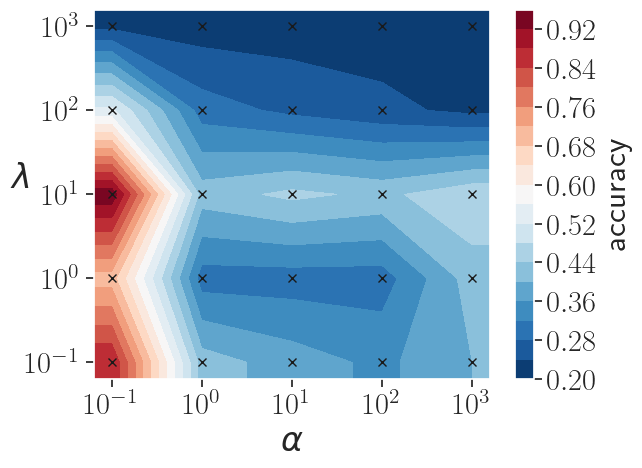

,0.1,1.0,10.0,100.0,1000.0
0.1,0.88,0.42,0.38,0.35,0.40
1.0,0.70,0.30,0.30,0.30,0.42
10.0,0.95,0.42,0.45,0.43,0.47
100.0,0.53,0.30,0.27,0.25,0.23
1000.0,0.23,0.22,0.22,0.22,0.23


\begin{tabular}{lrrrrr}
\toprule
 & 0.100000 & 1.000000 & 10.000000 & 100.000000 & 1000.000000 \\
\midrule
0.100000 & 0.9 & 0.4 & 0.4 & 0.3 & 0.4 \\
1.000000 & 0.7 & 0.3 & 0.3 & 0.3 & 0.4 \\
10.000000 & 0.9 & 0.4 & 0.4 & 0.4 & 0.5 \\
100.000000 & 0.5 & 0.3 & 0.3 & 0.2 & 0.2 \\
1000.000000 & 0.2 & 0.2 & 0.2 & 0.2 & 0.2 \\
\bottomrule
\end{tabular}



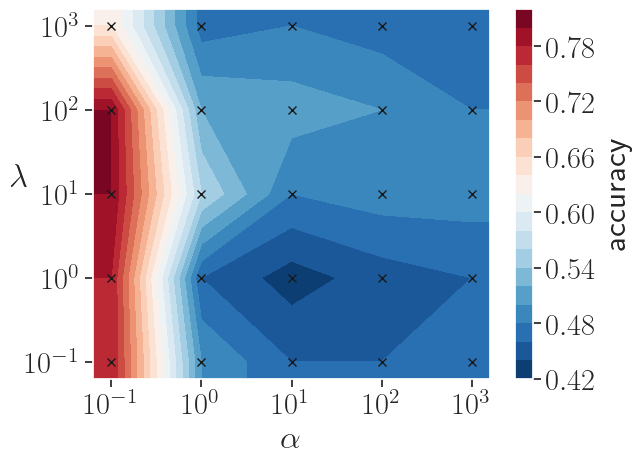

,0.1,1.0,10.0,100.0,1000.0
0.1,0.78,0.50,0.46,0.46,0.46
1.0,0.78,0.46,0.43,0.45,0.46
10.0,0.80,0.56,0.48,0.49,0.49
100.0,0.80,0.52,0.51,0.50,0.48
1000.0,0.64,0.47,0.48,0.47,0.48


\begin{tabular}{lrrrrr}
\toprule
 & 0.100000 & 1.000000 & 10.000000 & 100.000000 & 1000.000000 \\
\midrule
0.100000 & 0.8 & 0.5 & 0.5 & 0.5 & 0.5 \\
1.000000 & 0.8 & 0.5 & 0.4 & 0.4 & 0.5 \\
10.000000 & 0.8 & 0.6 & 0.5 & 0.5 & 0.5 \\
100.000000 & 0.8 & 0.5 & 0.5 & 0.5 & 0.5 \\
1000.000000 & 0.6 & 0.5 & 0.5 & 0.5 & 0.5 \\
\bottomrule
\end{tabular}



In [17]:
import matplotlib.ticker as ticker
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set(font_scale=2)
for i,results_cols in enumerate( [results_ground_cols,results_global_cols]):
#Ground


    table_df = pd.DataFrame(data=results_cols).transpose()

    #for wide df # and all coordinates
    lambdas_ =  []
    alphas_ = []
    values_ = []
    for l in lambdas: 
        for a in alphas:
            lambdas_.append(l)
            alphas_.append(a)
            values_.append(results_cols[(l, a)][0].split('±')[0])
    wide_df = pd.DataFrame({"alpha":alphas_,"lambda":lambdas_,"values":values_}).replace("--",0.00).astype("f")

    new_index = lambdas  #table_df.index.levels[0]
    new_columns = alphas #table_df.index.levels[1]
    table_cmap_df  = pd.DataFrame(
        data=[[f"{results_cols[(n, c)][0].split('±')[0]}" for c in new_columns] for n in new_index],
        index=pd.Index(new_index),
        columns=new_columns,
    )
    table_cmap_df = table_cmap_df.replace("--",0.00).astype("f")

    def pad_m(m):
        if isinstance(m,list):
            #pad coordinates o 10 log scale
            return [m[0]/10] + alphas + [m[-1]*10]
        else:
            return np.pad(m, ((1,1),(1,1)), 'edge')

    fig, ax = plt.subplots()
    ax.plot(np.log10(alphas_),np.log10(lambdas_), "xk")
    cntr = plt.contourf(np.log10(pad_m(new_columns)),np.log10(pad_m(new_index)),pad_m(table_cmap_df.to_numpy()), levels=20, cmap="RdBu_r",corner_mask=True) #extend="min", vmin=0.5,vmax=1.0

    plt.xlim(-1.2,3.2)
    plt.ylim(-1.2,3.2)
    ax.set_xticks(np.log10(alphas))
    ax.set_xticklabels(alphas)
    ax.set_yticks(np.log10(lambdas))
    ax.set_yticklabels(lambdas)
    for axis in [ax.xaxis, ax.yaxis]:
        #formatter.set_scientific(False)
        
        axis.set_major_formatter(ticker.FuncFormatter(lambda y, _: r'$10^{{{:g}}}$'.format(y)))


    plt.rcParams['text.usetex'] = True
    ax.set_ylabel(r"$\lambda$",rotation=0)
    ax.set_xlabel(r"$\alpha$")

    ax.tick_params(axis=u'both', which=u'both',reset=True,right=False,top=False)
    fig.colorbar(cntr, ax=ax, label="accuracy")
    

    dataset_name="synth_200D"
    plot_path = f"/home/kuehn/ot_metric_learning/damin-ggml/data/plots/{dataset_name}"
    plt.savefig(plot_path+f"/hyperparams_{'ground' if i == 0 else 'global'}_{t}.pdf")

    plt.show()
    ###

    ##
    '''
    print(wide_df)

    plt.figure()

    cmap = sns.color_palette("light:b", as_cmap=True) #"vlag_r"
    sns.heatmap(table_cmap_df,cmap=cmap, annot=True, fmt=".2f",cbar=False)
    plt.figure()

    print(wide_df)
    sns.kdeplot(
    data=wide_df,  x="alpha",y="lambda",log_scale=10,weights="values",levels=5,fill=True
    )
    plt.xlim(10**-1.2,10**3.2)
    plt.ylim(10**-1.2,10**3.2)

    plt.show()
    '''
    #table_df = table_df.reset_index(level=1)
    display(table_cmap_df)
    print(table_cmap_df.to_latex(index=True,
                    #formatters={"name": str.upper},
                    float_format="{:.1f}".format,
    ))
    
